In [1]:
import numpy as np
import pandas as pd
import os
import rasterio
from GeoDS import hypercube
from GeoDS.prospectivity import hyperparameterstuning
from GeoDS import utilities
from GeoDS.supervised import mapclass
from GeoDS import reporting
from GeoDS.prospectivity import featureimportance as fe
from GeoDS import eda
from GeoDS import datawrangle
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from joblib import dump, load
import glob
from dask import dataframe as dd

import optuna
from optuna import pruners
from imblearn.pipeline import Pipeline

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

#import tensorflow as tf
#import tensorflow_data_validation as tfdv
#from tensorflow_metadata.proto.v0 import schema_pb2

#print('TFDV Version: {}'.format(tfdv.__version__))
#print('Tensorflow Version: {}'.format(tf.__version__))

plt.rcParamsDefault["figure.figsize"] = [20., 20.]
plt.rcParams["figure.facecolor"] = 'white'
plt.rcParams["axes.facecolor"] = 'white'
plt.rcParams["savefig.facecolor"] = 'white'

from new_util import *
import xrspatial

In [2]:
def replace_classes(actual_classes, correspondance_dict):
    original_classes = [correspondance_dict[code] for code in actual_classes]
    return original_classes

In [3]:
crs = 'epsg:26918'
AOI = 'Inputs/AOI/shape/AOI_geol.shp'
pixel_size = 5
xRes = pixel_size
yRes = pixel_size

# Random seed
random_state = 42

In [4]:
import warnings
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from osgeo import gdal
import subprocess
import os
import rioxarray as rio
from scipy.spatial import distance_matrix
from GeoDS import utilities
import itertools
import pandas as pd
import geopandas
import rasterio
import matplotlib.pyplot as plt
from geocube.api.core import make_geocube
import math
from libpysal.weights import Queen, Rook, KNN, DistanceBand
from esda.getisord import G_Local
from esda.moran import Moran_Local
import rioxarray
import xrspatial
import xarray

def _dataframe_to_xarray(input_df, columns, x_field, y_field, dstCRS):
    if (x_field != None and y_field != None):
        try:
            input_df.rename(columns={x_field: 'x', y_field: 'y'}, inplace=True)
        except KeyError:
            print('x or y columns names are not found in your input data. Check x_field and y_field arguments.')

        input_df = input_df.set_index(['x', 'y'])
        input_df.dropna(how='any', inplace=True)

        xr = input_df.to_xarray()
        xr = xr.rio.set_spatial_dims('x', 'y')
        try:
            xr = xr.rio.write_crs(dstCRS)
        except KeyError:
            print("The provided CRS cannot be used by xarray. Check the spelling")

        xr = xr.transpose('y', 'x')

    return xr

def _geotiff_to_xarray(input_geotiff):
    xds = rio.open_rasterio(input_geotiff)
    # WE ARE ASSUMING THIS IS A SINGLE BAND XARRAY OTHERWISE WE MAY HAVE ISSUES
    name = input_geotiff.replace('.tif', '')
    df = xds.to_dataframe(name=name)

    nodata_val = xds._FillValue
    if (nodata_val != None):
        df = df.replace(nodata_val, np.nan)

    df = df.dropna(how='any')
    df.reset_index(inplace=True)
    df = df.drop(columns=['band', 'spatial_ref'])
    # columns=[name]

    df = df.set_index(['x', 'y'])
    df.dropna(how='any', inplace=True)

    xr = df.to_xarray()
    xr = xr.rio.set_spatial_dims('x', 'y')

    dstCRS = xds.rio.crs
    try:
        xr = xr.rio.write_crs(dstCRS)
    except KeyError:
        print("The provided CRS cannot be used by xarray. Check the spelling")

    xr = xr.transpose('y', 'x')
    return xr

def moving_window_statistics(input_data, output_directory, dstCRS, kernel, columns=None, x_field=None,
                     y_field=None, stats=['mean', 'max', 'min', 'range', 'std', 'var', 'sum']):
    """
    Calculates statistics of the values within a specified focal neighborhood for each pixel in an input raster, csv or pandas DataFrame. The statistics types are Mean, Maximum, Minimum, Range, Standard deviation, Variation and Sum.
    Outputs will be a geotiff for each statistic you want to calculate.
    Parameters
    ----------
    input_data : str, pandas.DataFrame
        Input, can be a string (file.csv or file.tif) or a pandas DataFrame
    output_directory : str
        path to the output directory
    dstCRS : str
        valid CRS, example 'epsg:26921'
    kernel : bytearray
        2d kernel/moving window for searching the neighborhood.
        eg:
    columns : list, default = None
        list of the columns to use in case input data is a csv or DataFrame
    x_field : str
        name of x coordinate field (csv/DataFrame)
    y_field : str
        name of y coordinate field (csv/DataFrame)
    stats : list, default = ['mean', 'max', 'min', 'range', 'std', 'var', 'sum']
        list of statistics to calculate (['mean', 'max', 'min', 'range', 'std', 'var', 'sum'])
    Returns
    -------
    True
                
    Example #1
    ----------
        input_data = '06_Geophysics_tifs/IPL_DEM_GPM_win.tif'
        output_directory = 'stat_features_window_kernel_5_5'
        dstCRS = 'epsg:26912'
        x_res = 20.0
        y_res = 20.0
        # radius = 5
        # define square kernel to the moving window stats
        square_kernel = xrspatial.convolution.custom_kernel(np.ones([5,5]))
        # circle_kernel = xrspatial.convolution.circle_kernel(1, 1, radius)
        # pass any one kernel
        moving_window_statistics(input_data,
            output_directory, 
            dstCRS, 
            x_res,
            y_res,
            kernel=square_kernel, 
            columns=None,
            x_field=None,
            y_field=None, 
            stats=['mean', 'max', 'min', 'range', 'std', 'var', 'sum'])
    Example #2
    ----------
        input_data = 'PCA_SOM_Agglomerative/outputs/hypercube_06-09-2022_1514.csv'
        output_directory = 'stat_features_window_kernel_5_5_test'
        dstCRS = 'epsg:26912'
        x_res = 20.0
        y_res = 20.0
        radius = 50
        # define square kernel to the moving window stats
        # square_kernel = xrspatial.convolution.custom_kernel(np.ones([5,5]))
        circle_kernel = xrspatial.convolution.circle_kernel(1, 1, radius)
        # pass any one kernel
        columns = ['IPL_RTP_GPM_win', 'IPL_DEM_GPM_win', 'IPL_RTP_VD2_GPM_win',
            'IPL_RTP_AS_GPM_win', 'IPL_RTP_HD_GPM_win', 'IPL_RTP_VD1_GPM_win',
            'IPL_RTP_tilt_GPM_win', 'IPL_RTP_grav_GPM_win']
        moving_window_statistics(input_data,
            output_directory, 
            dstCRS, 
            x_res,
            y_res,
            kernel=square_kernel, 
            columns=columns,
            x_field='x',
            y_field='y', 
            stats=['mean', 'max', 'min', 'range', 'std', 'var', 'sum'])                    
    """
    # available stats functions : ['mean', 'max', 'min', 'range', 'std', 'var', 'sum']
    if (type(input_data) == str):
        if (input_data.endswith('.csv')):
            xr = _csv_to_xarray(input_data, columns, x_field, y_field, dstCRS)
        elif (input_data.endswith('.tif')):
            xr = _geotiff_to_xarray(input_data)
            columns = list(xr.keys())
    elif (type(input_data) == pd.DataFrame):
        xr = _dataframe_to_xarray(input_data, columns, x_field, y_field, dstCRS)
    else:
        print("Type for input data should be a .csv file or .tif file or a pandas dataframe. " + str(
            type(input_data)) + "not supported")
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    created = []
    for col in columns:
        var_calculated = xrspatial.focal.focal_stats(xr[col], kernel, stats_funcs=stats)
        var_calculated = var_calculated.fillna(-9999)
        var_calculated = var_calculated.where(var_calculated != -9999)
        var_calculated.rio.write_nodata(-9999, inplace=True)
        for s in stats:
            index = stats.index(s)
            if (type(input_data) == str):
                if (input_data.endswith('.csv')):
                    name = col + '_' + s + '_r' + str(kernel.shape[0])
                elif (input_data.endswith('.tif')):
                    basename = os.path.basename(col)
                    name = basename + '_' + s + '_r' + str(kernel.shape[0])
            elif (type(input_data) == pd.DataFrame):
                name = col + '_' + s + '_r' + str(kernel.shape[0])
            outpath = os.path.join(output_directory, name)
            temp_df = var_calculated[index].to_dataframe(name=name).reset_index()
            temp_df = temp_df[['y','x',name]]
            df_to_gtiffs(temp_df,dstCRS,outfolder=output_directory,x_col='x',y_col='y',features=name,nodata=-9999,verbose=True)
            # Changed from rioxarray based tiff writing to rasterio based to counter spatial discontinuity in data.
            # rewarped = var_calculated[index].rio.reproject(dst_crs=dstCRS, resolution=x_res, shape=None, transform=None,
            #                                                resampling=2, nodata=-9999)
            # rewarped.rio.to_raster(raster_path=outpath, nodata=-9999)
            created.append(outpath)
    print("Moving window statistics computed. Results :")
    print(*created, sep='\n')
    return

In [17]:
if __name__ == "__main__":
    import xrspatial
    import importlib
    import GeoDS #import the module here, so that it can be reloaded.
    importlib.reload(GeoDS)
    input_data = 'Inputs/Features/Raster/Critical_1yd.tif'
    output_directory = 'Inputs/Features/Raster/moving_windows_r5'
    dstCRS = crs
    x_res = pixel_size
    y_res = pixel_size
    # radius = 5
    # define square kernel to the moving window stats
    square_kernel = xrspatial.convolution.custom_kernel(np.ones([5, 5]))
    kernel = square_kernel

    moving_window_statistics(input_data,output_directory, dstCRS, kernel, columns=None, x_field=None,
                     y_field=None, stats=['mean', 'max', 'min', 'range', 'std', 'var', 'sum'] )


inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/Critical_1yd_mean_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/Critical_1yd_max_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/Critical_1yd_min_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/Critical_1yd_range_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/Critical_1yd_std_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/Critical_1yd_var_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/Critical_1yd_sum_r5.tif
Moving window statistics computed. Results :
Inputs/Features/Raster/moving_windo

In [19]:
if __name__ == "__main__":
    import xrspatial
    import importlib
    import GeoDS #import the module here, so that it can be reloaded.
    importlib.reload(GeoDS)
    input_data = 'Inputs/Features/Raster/Critical_1xd.tif'
    output_directory = 'Inputs/Features/Raster/moving_windows_r5'
    dstCRS = crs
    x_res = pixel_size
    y_res = pixel_size
    # radius = 5
    # define square kernel to the moving window stats
    square_kernel = xrspatial.convolution.custom_kernel(np.ones([5, 5]))
    kernel = square_kernel

    moving_window_statistics(input_data,output_directory, dstCRS, kernel, columns=None, x_field=None,
                     y_field=None, stats=['mean', 'max', 'min', 'range', 'std', 'var', 'sum'] )


inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/Critical_1xd_mean_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/Critical_1xd_max_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/Critical_1xd_min_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/Critical_1xd_range_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/Critical_1xd_std_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/Critical_1xd_var_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/Critical_1xd_sum_r5.tif
Moving window statistics computed. Results :
Inputs/Features/Raster/moving_windo

In [20]:
if __name__ == "__main__":
    import xrspatial
    import importlib
    import GeoDS #import the module here, so that it can be reloaded.
    importlib.reload(GeoDS)
    input_data = 'Inputs/Features/Raster/Critical_DTM_slope.tif'
    output_directory = 'Inputs/Features/Raster/moving_windows_r5'
    dstCRS = crs
    x_res = pixel_size
    y_res = pixel_size
    # radius = 5
    # define square kernel to the moving window stats
    square_kernel = xrspatial.convolution.custom_kernel(np.ones([5, 5]))
    kernel = square_kernel

    moving_window_statistics(input_data, output_directory, dstCRS, kernel, columns=None, x_field=None,
                     y_field=None, stats=['mean', 'max', 'min', 'range', 'std', 'var', 'sum'] )

inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/Critical_DTM_slope_mean_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/Critical_DTM_slope_max_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/Critical_DTM_slope_min_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/Critical_DTM_slope_range_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/Critical_DTM_slope_std_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/Critical_DTM_slope_var_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/Critical_DTM_slope_sum_r5.tif
Moving window statistics computed. Res

In [21]:
if __name__ == "__main__":
    import xrspatial
    import importlib
    import GeoDS #import the module here, so that it can be reloaded.
    importlib.reload(GeoDS)
    input_data = 'Inputs/Features/Raster/cre_dtm_curvature.tif'
    output_directory = 'Inputs/Features/Raster/moving_windows_r5'
    dstCRS = crs
    x_res = pixel_size
    y_res = pixel_size
    # radius = 5
    # define square kernel to the moving window stats
    square_kernel = xrspatial.convolution.custom_kernel(np.ones([5, 5]))
    kernel = square_kernel

    moving_window_statistics(input_data, output_directory, dstCRS, kernel, columns=None, x_field=None,
                     y_field=None, stats=['mean', 'max', 'min', 'range', 'std', 'var', 'sum'] )

inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/cre_dtm_curvature_mean_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/cre_dtm_curvature_max_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/cre_dtm_curvature_min_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/cre_dtm_curvature_range_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/cre_dtm_curvature_std_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/cre_dtm_curvature_var_r5.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r5/cre_dtm_curvature_sum_r5.tif
Moving window statistics computed. Results :


In [28]:
def Path_Info(input_path):
    """
    Gives the name of a file, its extension and the path to host directory, for a given path.
    Parameters
    ----------
    input_path : str
        Path to a file
    Returns
    -------
    str
        name of the file (without extension)
    str
        extension of the file
    str
        host directory
    """
    path_obj = Path(input_path)
    # gives just the input name
    name = path_obj.stem
    extension = path_obj.suffix
    directory = str(path_obj.parent)

    return name, extension, directory


import numpy.ma as ma

def geotiff_to_jpg(input_geotiff, output_path, nb_quantiles=20):
    """
    Convert a raster (geotiff) to jpg and show it in the console.

    Parameters
    ----------
    input_geotiff : str
        path to input geotiff
    output_path : str
        full path to save the jpg.
    nb_quantiles : int, default=20
        number of quantiles to use to bin the data into equals interval for the colorscale (Turbo). Default = 20

    Returns
    -------
    fig : Matplotlib.Figure
        Figure from matplotlib
    ax : Matplotlib.Axe
        Axe object from matplotlib

    Examples
    --------
        Convert a batch of PCs geotiffs from a folder and save them as jpg.

        >>> import glob
        >>> import os
        >>> input_folder = 'my_pcs_rasters/'
        >>> my_output_folder = 'my_jpgs/'
        >>> tifs = glob.glob(input_folder + '*.tif')
        >>> for t in tifs:
        >>>     filename,  extension, directory= utilities.Path_Info(t)
        >>>     utilities.raster_to_jpg(t, os.path.join(my_output_folder, filename + '.jpg'))

    """
    dataset = gdal.Open(input_geotiff, gdal.GA_ReadOnly)
    # Note GetRasterBand() takes band no. starting from 1 not 0
    band = dataset.GetRasterBand(1)
    arr = band.ReadAsArray()
    data = np.array(arr)

    # The function was creating a vertical block when there was a discontinuity in the data 
    # although there is no vertical block in geotiff.
    # This issue is resolved by masking/ignoring the NoData values as follows:
    ndv1 = 0.00000000e+00
    ndv2 = -9.99900000e+03
    masked_data = ma.masked_where((data == ndv1) | (data == ndv2), data)

    #need to flip the data (y are negative)
    masked_data = np.flipud(masked_data)
    increment = 1 / nb_quantiles
    bounds = np.nanquantile(data, np.arange(0, 1, increment))
    cmap = colors.Colormap('turbo')
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N)
    plt.rcParams["figure.figsize"] = (10, 10)
    fig, ax = plt.subplots()
    plt.imshow(masked_data, origin='lower',cmap='turbo', norm=norm, interpolation='bicubic')  # norm=colors.TwoSlopeNorm(vcenter=0))

    plt.axis('off')
    # X-axis tick label
    # plt.xticks(color='w')
    # Y-axis tick label
    # plt.yticks(color='w')
    # plt.tick_params(left=False,bottom=False)
    plt.box(False)
    plt.tight_layout()
    # be sure not to cause crashe
    filename, extension, directory = Path_Info(input_geotiff)
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig(output_path)
    plt.show()

    return fig, ax, data

In [32]:
filepath

'Inputs/Features/Raster/moving_windows_r3/'

Critical_1xd_max_r5


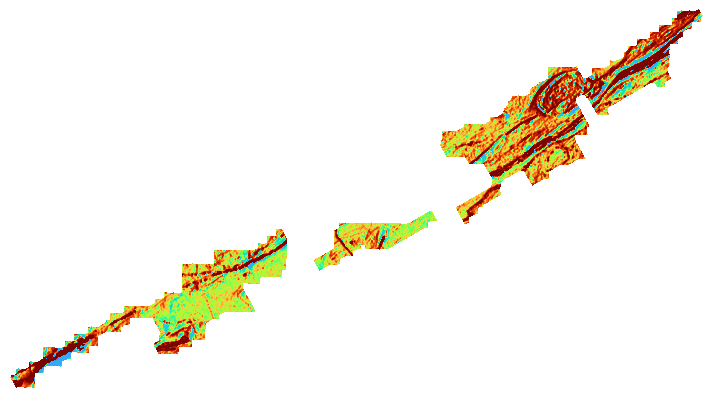

Critical_1xd_var_r5


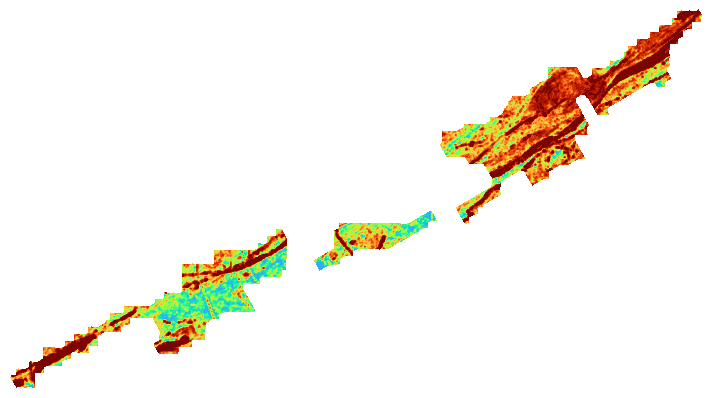

Critical_DTM_slope_std_r5


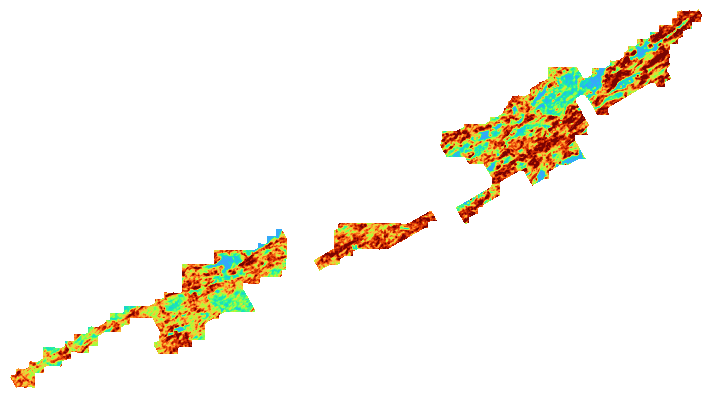

cre_dtm_curvature_max_r5


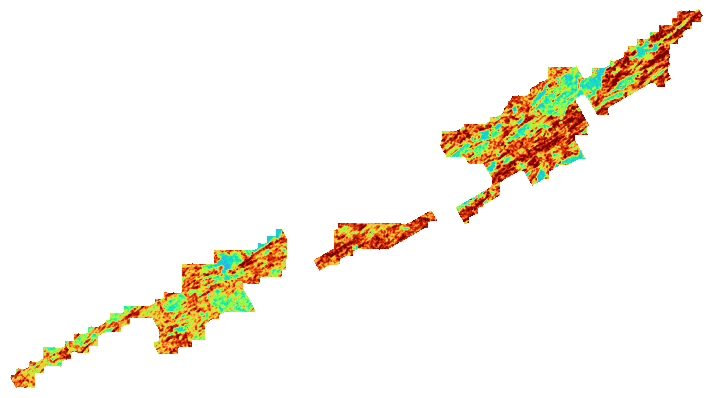

Critical_1xd_mean_r5


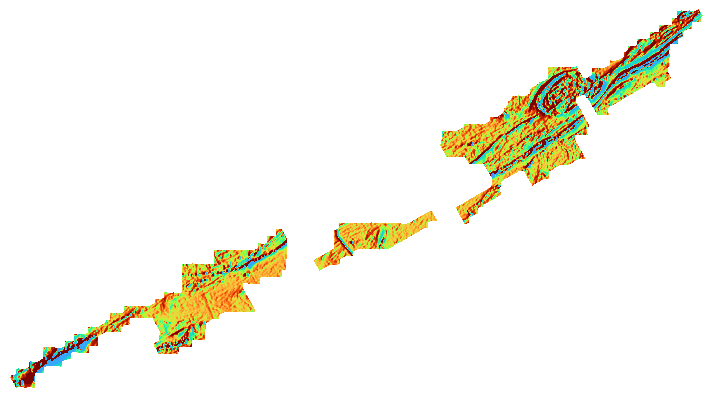

Critical_1yd_min_r5


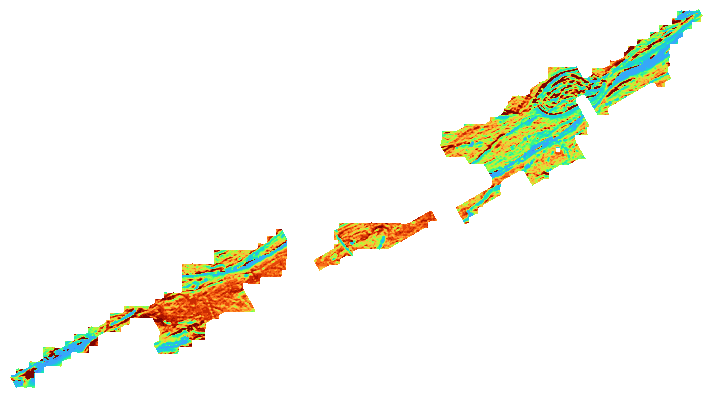

Critical_1yd_std_r5


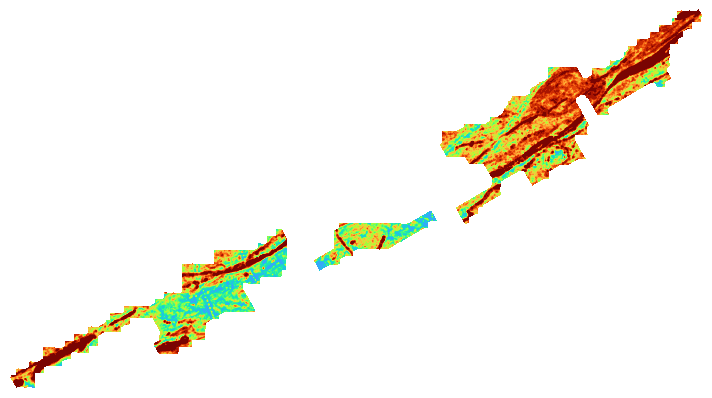

cre_dtm_curvature_range_r5


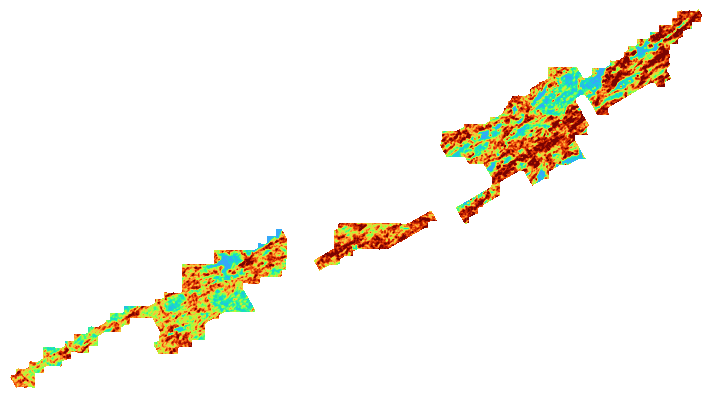

Critical_1yd_range_r5


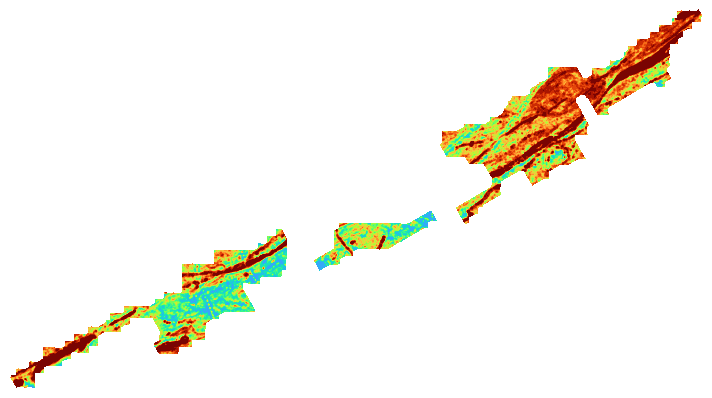

cre_dtm_curvature_sum_r5


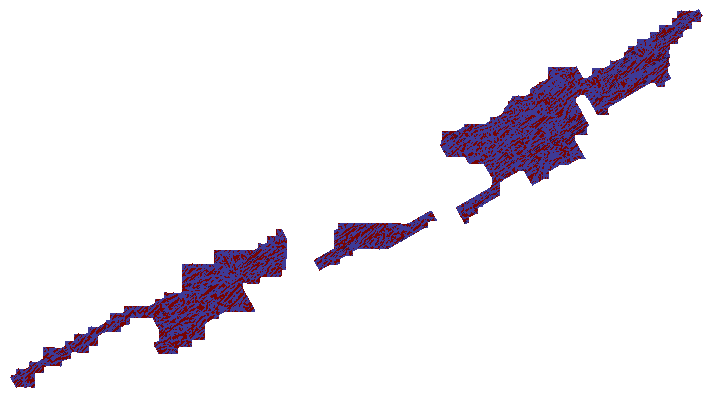

Critical_1xd_range_r5


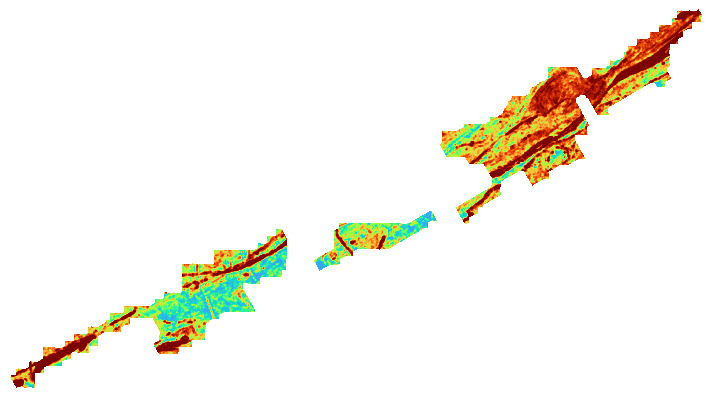

Critical_DTM_slope_range_r5


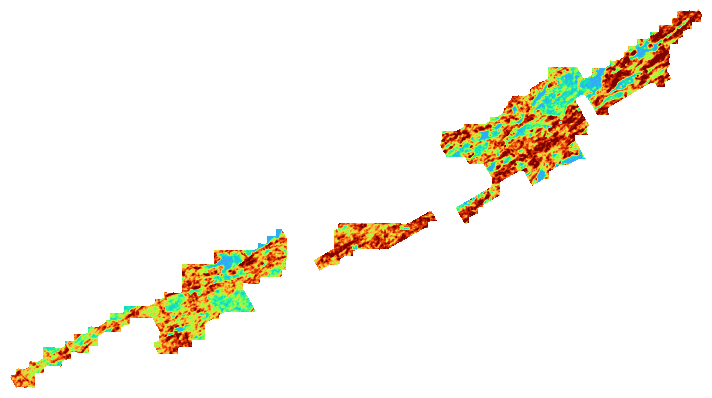

Critical_1xd_min_r5


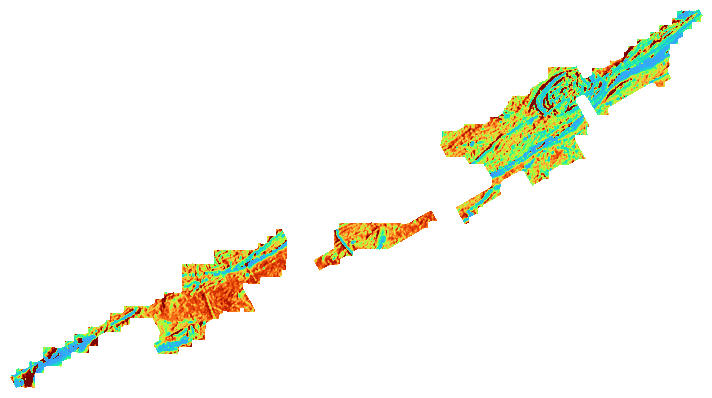

Critical_DTM_slope_max_r5


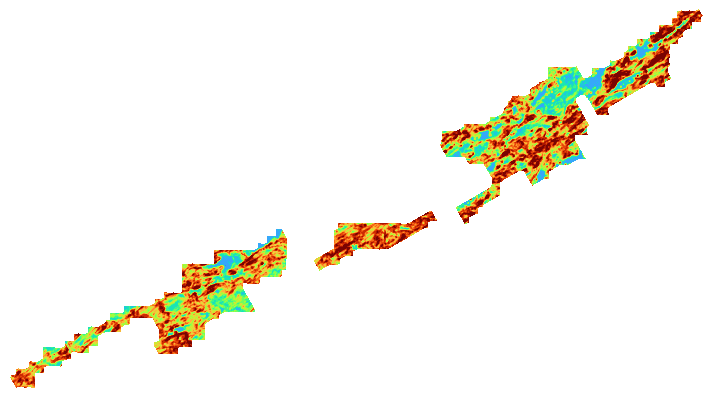

cre_dtm_curvature_min_r5


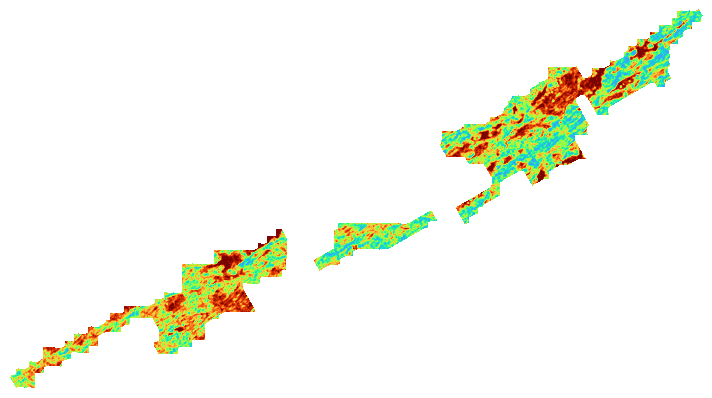

cre_dtm_curvature_mean_r5


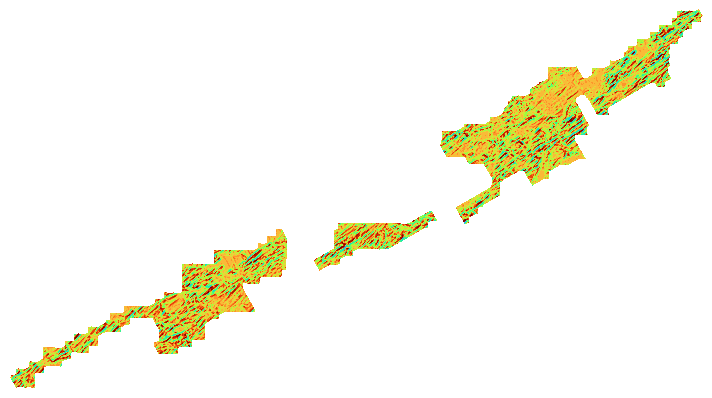

Critical_1yd_sum_r5


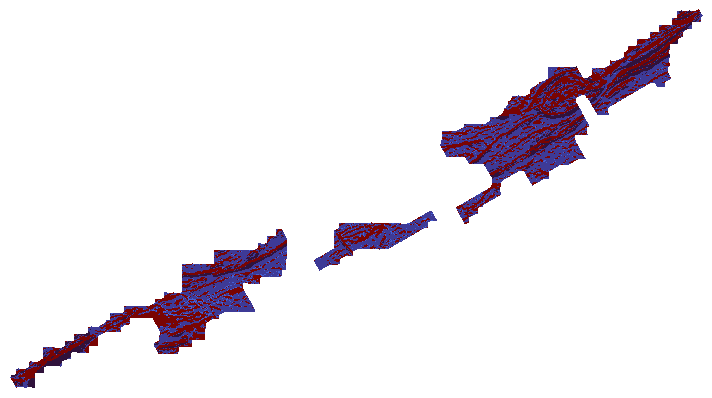

Critical_DTM_slope_min_r5


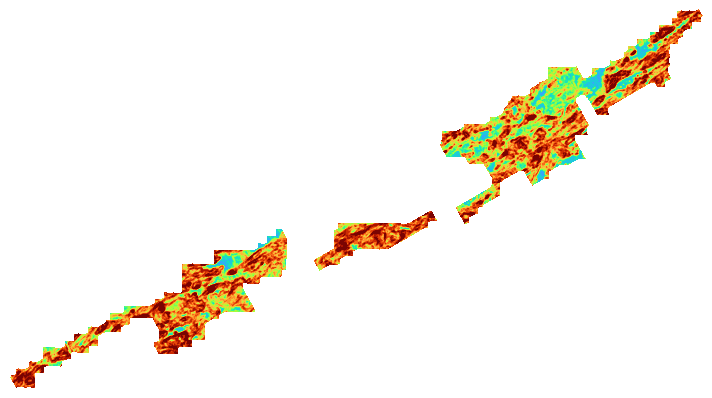

Critical_1xd_std_r5


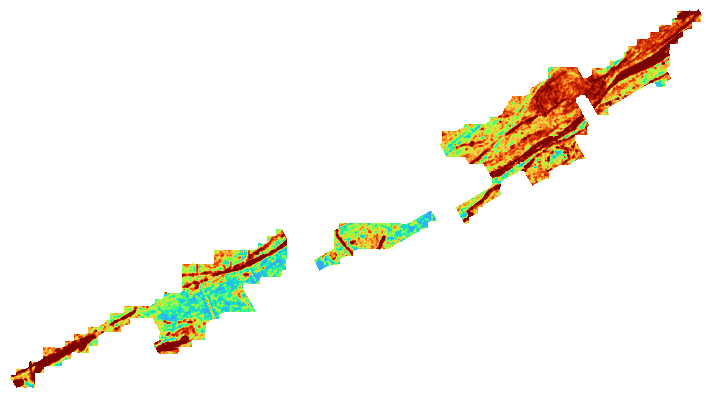

Critical_1yd_max_r5


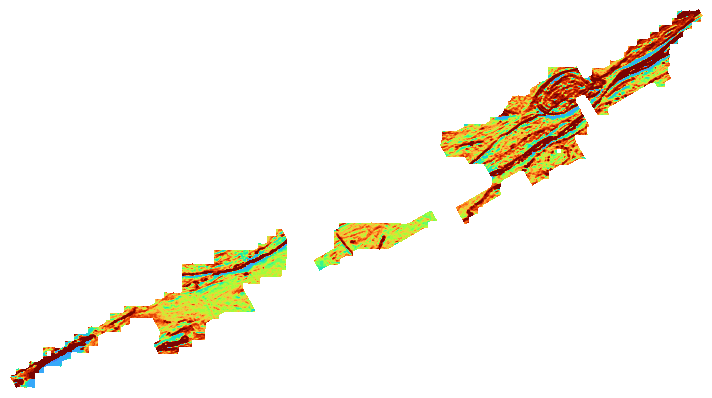

Critical_DTM_slope_var_r5


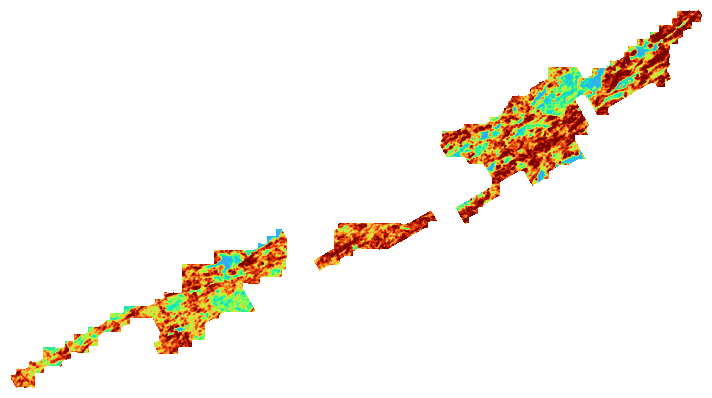

cre_dtm_curvature_var_r5


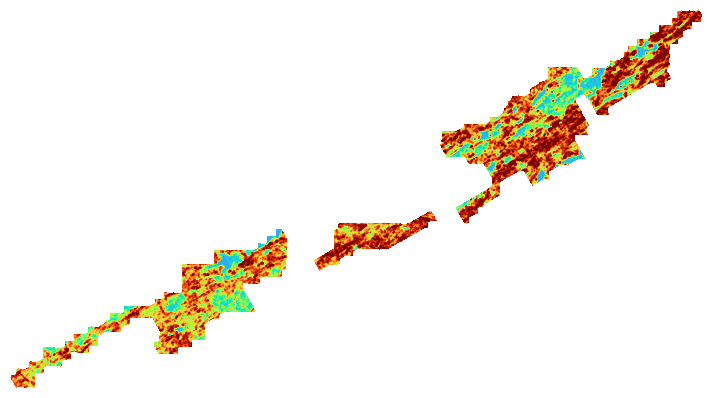

Critical_1yd_var_r5


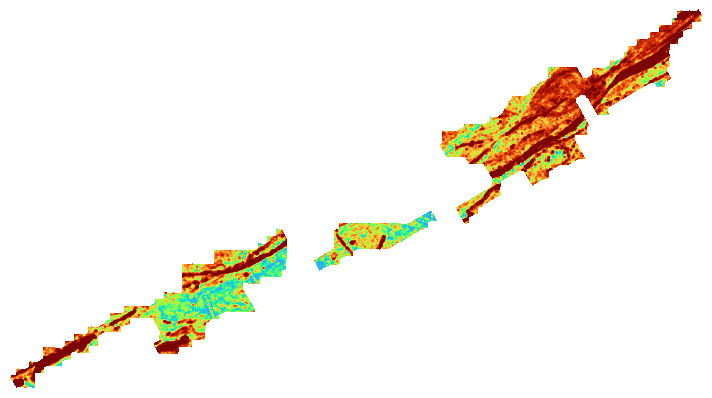

Critical_1yd_mean_r5


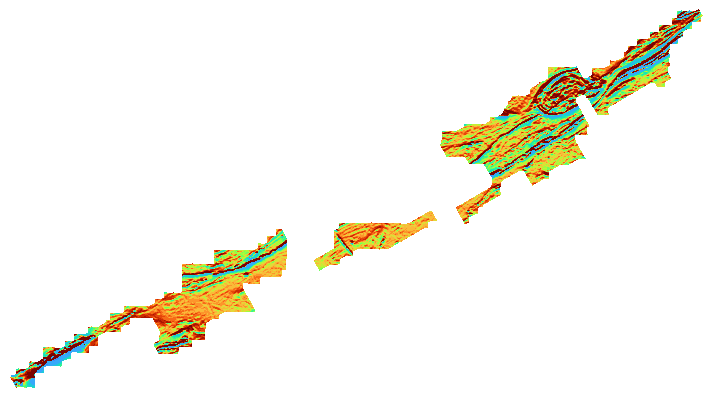

Critical_DTM_slope_sum_r5


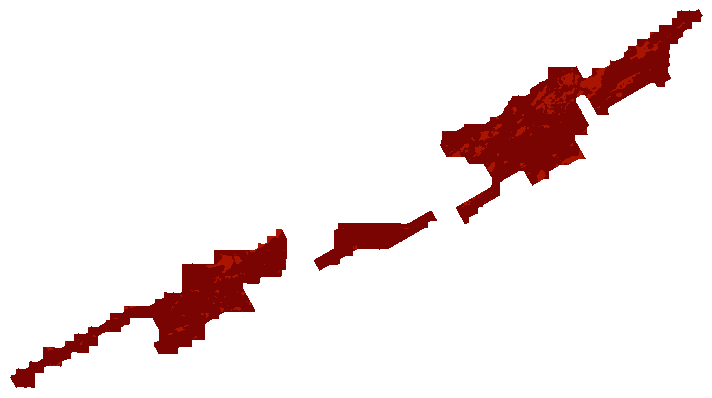

Critical_DTM_slope_mean_r5


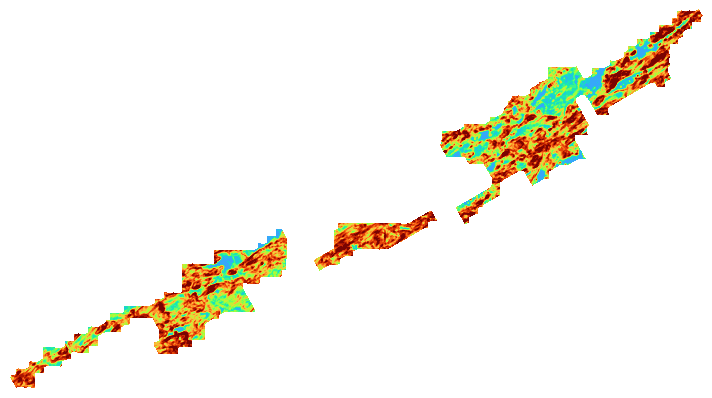

cre_dtm_curvature_std_r5


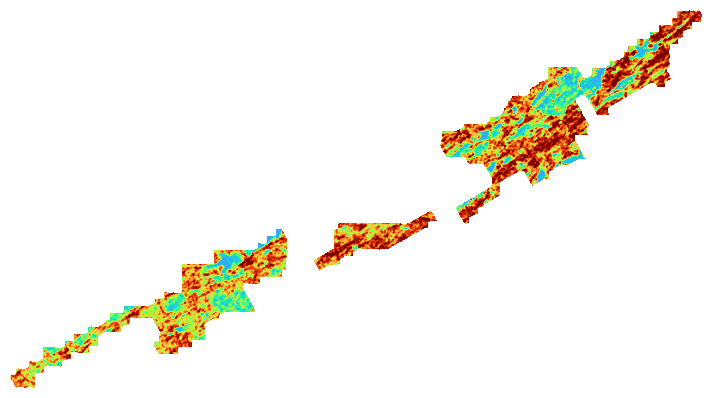

Critical_1xd_sum_r5


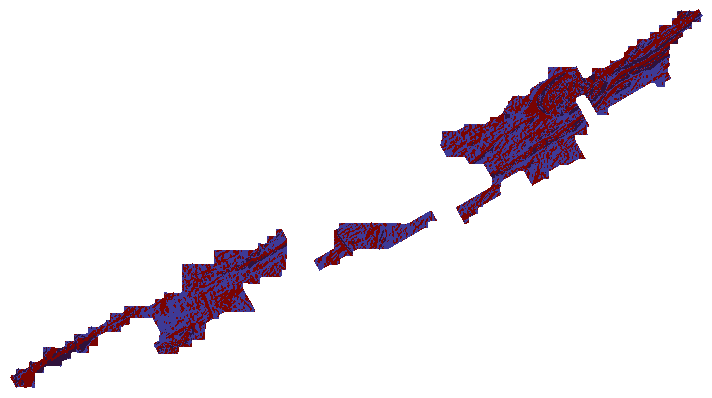

In [30]:
filepath = 'Inputs/Features/Raster/moving_windows_r5/'
tifs = glob.glob(filepath + '*.tif')

for t in tifs:
    filename,  extension, directory= utilities.Path_Info(t)
    print(filename)
    fig, ax, data = geotiff_to_jpg(t, os.path.join(filepath, filename + '.jpg'))

In [22]:
u, count = np.unique(data, return_counts=True)

In [23]:
count_sort_ind = np.argsort(-count)

In [24]:
u[count_sort_ind]

array([ 0.00000000e+00, -9.99900000e+03, -2.09313348e-01, ...,
       -3.41599131e+00, -3.41646314e+00,  4.93433350e+03])

In [25]:
count[count_sort_ind]

array([24526253,   874248,        6, ...,        1,        1,        1])

In [ ]:
u, count = np.unique(my_chr_list, return_counts=True)

In [35]: count_sort_ind = np.argsort(-count)

In [36]: u[count_sort_ind]
Out[36]: 
array(['a', 'b', 'd', 'c'], 
      dtype='<U1')

In [37]: count[count_sort_ind]
Out[37]: array([3, 2, 2, 1])

In [19]:
np.min(data)

-9999.0

In [23]:
if __name__ == "__main__":
    import xrspatial
    import importlib
    import GeoDS #import the module here, so that it can be reloaded.
    importlib.reload(GeoDS)
    input_data = 'Inputs/Features/Raster/Critical_1yd.tif'
    output_directory = 'Inputs/Features/Raster/moving_windows_r3'
    dstCRS = crs
    x_res = pixel_size
    y_res = pixel_size
    # radius = 5
    # define square kernel to the moving window stats
    square_kernel = xrspatial.convolution.custom_kernel(np.ones([3, 3]))
    kernel = square_kernel

    moving_window_statistics(input_data,output_directory, dstCRS, kernel, columns=None, x_field=None,
                     y_field=None, stats=['mean', 'max', 'min', 'range', 'std', 'var', 'sum'] )


inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/Critical_1yd_mean_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/Critical_1yd_max_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/Critical_1yd_min_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/Critical_1yd_range_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/Critical_1yd_std_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/Critical_1yd_var_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/Critical_1yd_sum_r3.tif
Moving window statistics computed. Results :
Inputs/Features/Raster/moving_windo

In [24]:
if __name__ == "__main__":
    import xrspatial
    import importlib
    import GeoDS #import the module here, so that it can be reloaded.
    importlib.reload(GeoDS)
    input_data = 'Inputs/Features/Raster/Critical_1xd.tif'
    output_directory = 'Inputs/Features/Raster/moving_windows_r3'
    dstCRS = crs
    x_res = pixel_size
    y_res = pixel_size
    # radius = 5
    # define square kernel to the moving window stats
    square_kernel = xrspatial.convolution.custom_kernel(np.ones([3, 3]))
    kernel = square_kernel

    moving_window_statistics(input_data,output_directory, dstCRS, kernel, columns=None, x_field=None,
                     y_field=None, stats=['mean', 'max', 'min', 'range', 'std', 'var', 'sum'] )


inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/Critical_1xd_mean_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/Critical_1xd_max_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/Critical_1xd_min_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/Critical_1xd_range_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/Critical_1xd_std_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/Critical_1xd_var_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/Critical_1xd_sum_r3.tif
Moving window statistics computed. Results :
Inputs/Features/Raster/moving_windo

In [25]:
if __name__ == "__main__":
    import xrspatial
    import importlib
    import GeoDS #import the module here, so that it can be reloaded.
    importlib.reload(GeoDS)
    input_data = 'Inputs/Features/Raster/Critical_DTM_slope.tif'
    output_directory = 'Inputs/Features/Raster/moving_windows_r3'
    dstCRS = crs
    x_res = pixel_size
    y_res = pixel_size
    # radius = 5
    # define square kernel to the moving window stats
    square_kernel = xrspatial.convolution.custom_kernel(np.ones([3, 3]))
    kernel = square_kernel

    moving_window_statistics(input_data, output_directory, dstCRS, kernel, columns=None, x_field=None,
                     y_field=None, stats=['mean', 'max', 'min', 'range', 'std', 'var', 'sum'] )

inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/Critical_DTM_slope_mean_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/Critical_DTM_slope_max_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/Critical_DTM_slope_min_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/Critical_DTM_slope_range_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/Critical_DTM_slope_std_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/Critical_DTM_slope_var_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/Critical_DTM_slope_sum_r3.tif
Moving window statistics computed. Res

In [26]:
if __name__ == "__main__":
    import xrspatial
    import importlib
    import GeoDS #import the module here, so that it can be reloaded.
    importlib.reload(GeoDS)
    input_data = 'Inputs/Features/Raster/cre_dtm_curvature.tif'
    output_directory = 'Inputs/Features/Raster/moving_windows_r3'
    dstCRS = crs
    x_res = pixel_size
    y_res = pixel_size
    # radius = 5
    # define square kernel to the moving window stats
    square_kernel = xrspatial.convolution.custom_kernel(np.ones([3, 3]))
    kernel = square_kernel

    moving_window_statistics(input_data, output_directory, dstCRS, kernel, columns=None, x_field=None,
                     y_field=None, stats=['mean', 'max', 'min', 'range', 'std', 'var', 'sum'] )

inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/cre_dtm_curvature_mean_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/cre_dtm_curvature_max_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/cre_dtm_curvature_min_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/cre_dtm_curvature_range_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/cre_dtm_curvature_std_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/cre_dtm_curvature_var_r3.tif
inferred resolution from coordinates is 12.5

1 geotiffs written.
Inputs/Features/Raster/moving_windows_r3/cre_dtm_curvature_sum_r3.tif
Moving window statistics computed. Results :


Critical_DTM_slope_mean_r3


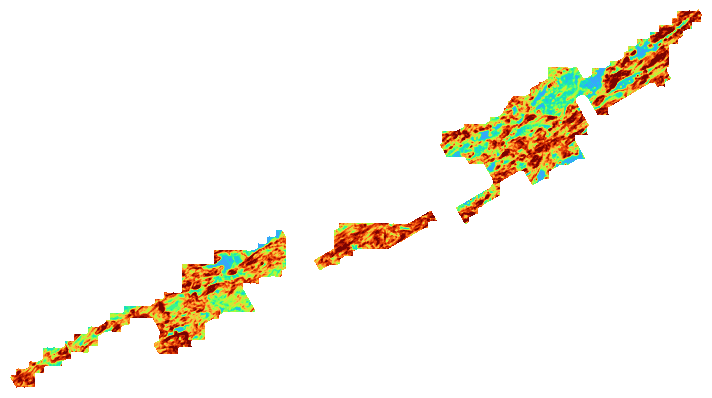

Critical_DTM_slope_min_r3


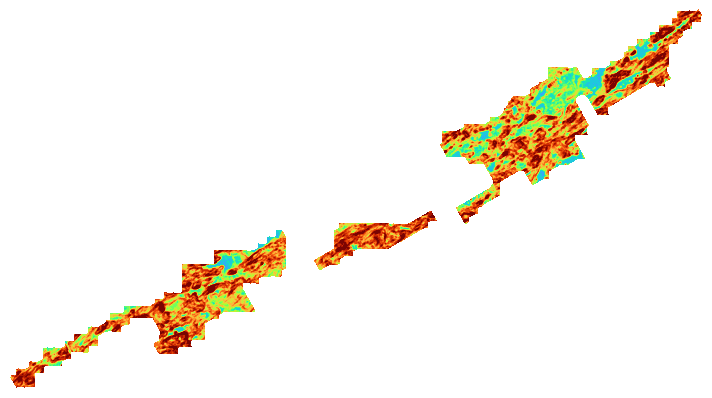

cre_dtm_curvature_std_r3


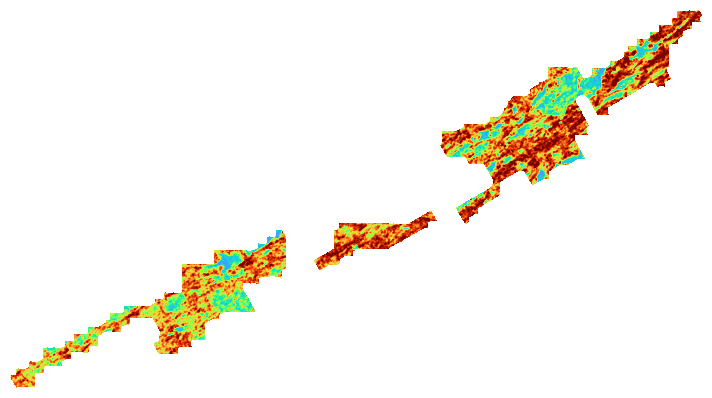

cre_dtm_curvature_range_r3


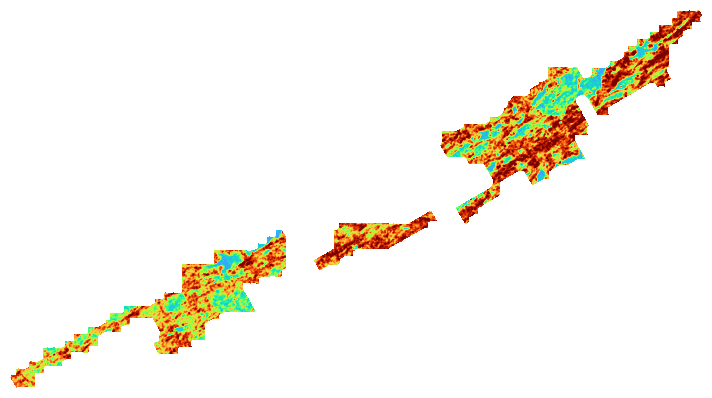

cre_dtm_curvature_sum_r3


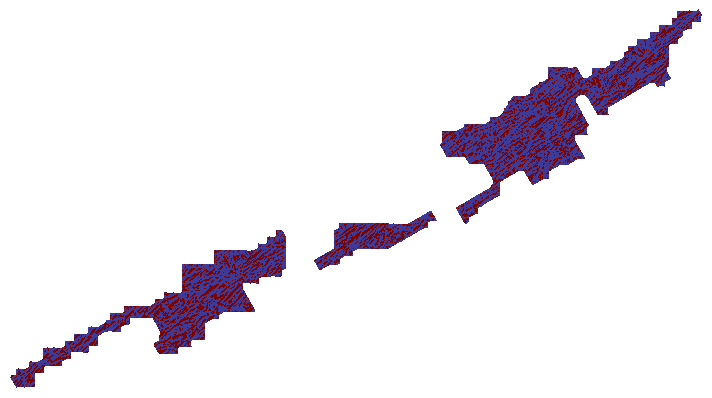

Critical_1xd_min_r3


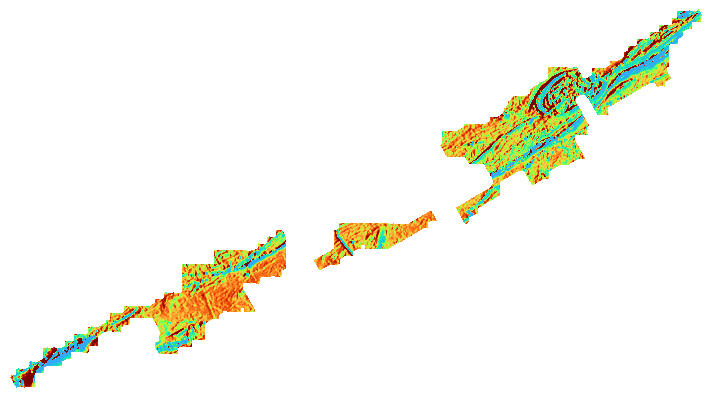

Critical_1yd_max_r3


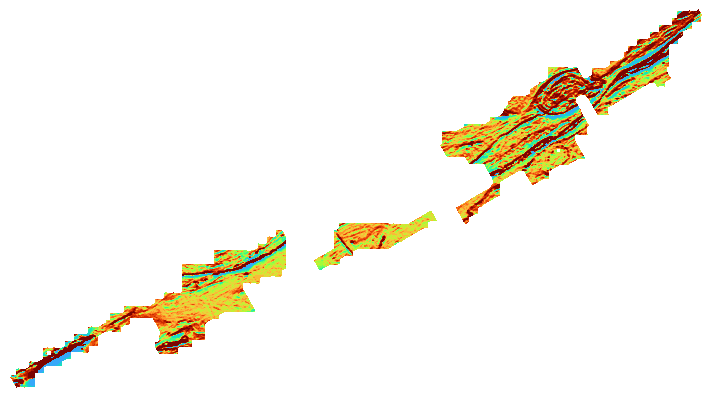

Critical_1yd_std_r3


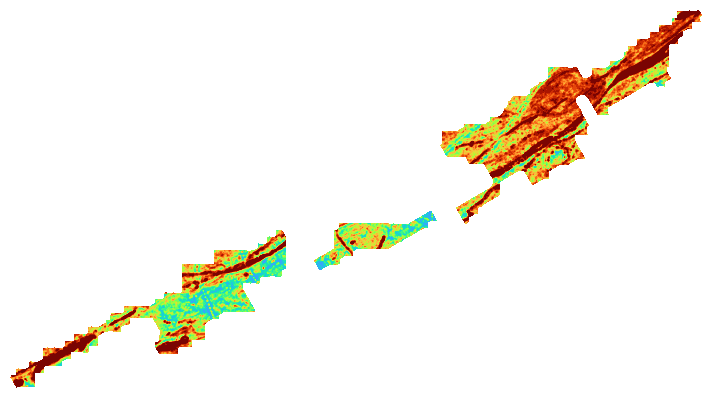

cre_dtm_curvature_var_r3


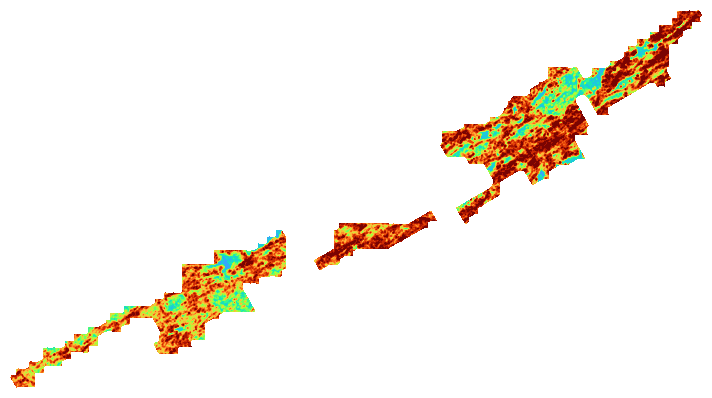

Critical_DTM_slope_sum_r3


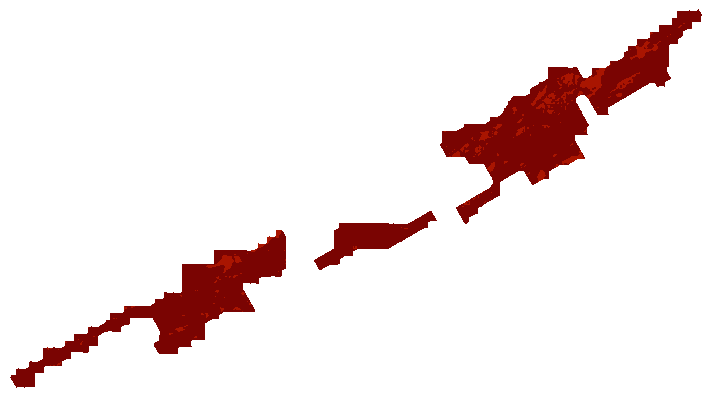

Critical_DTM_slope_std_r3


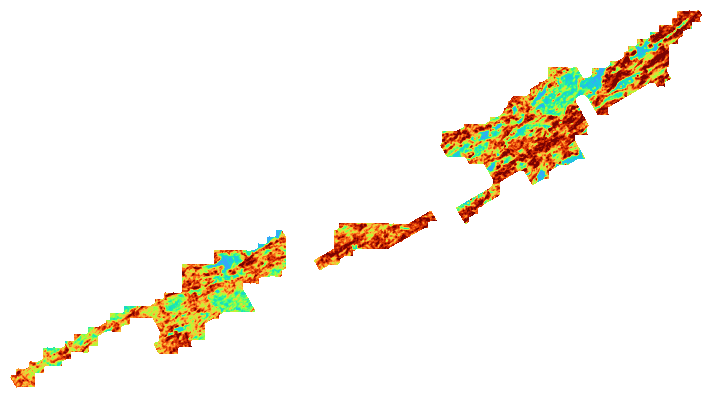

Critical_1yd_mean_r3


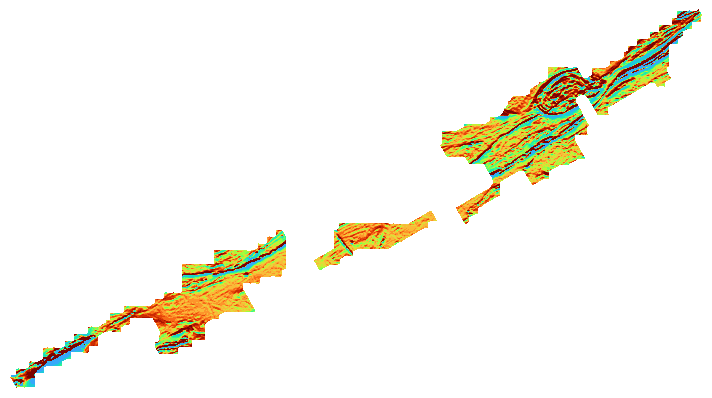

Critical_1yd_var_r3


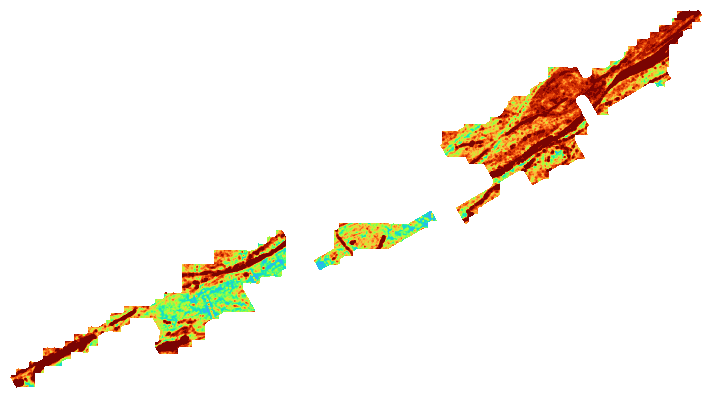

Critical_DTM_slope_max_r3


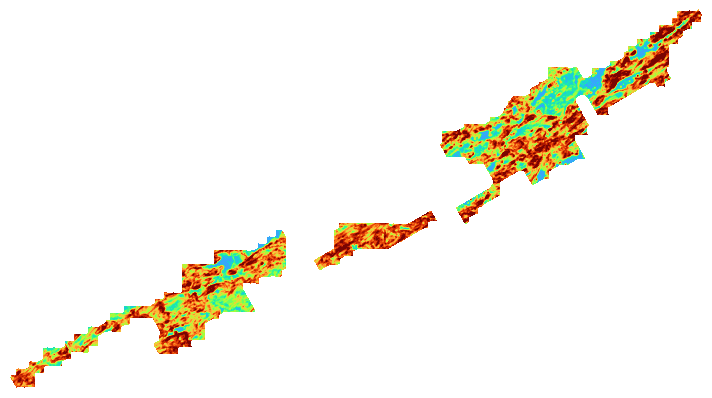

Critical_1xd_range_r3


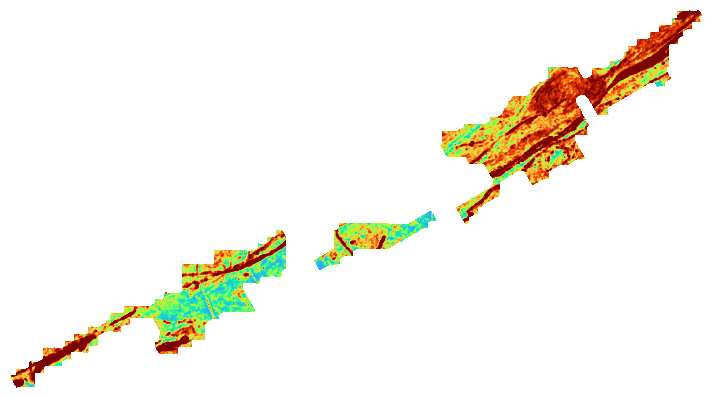

Critical_DTM_slope_range_r3


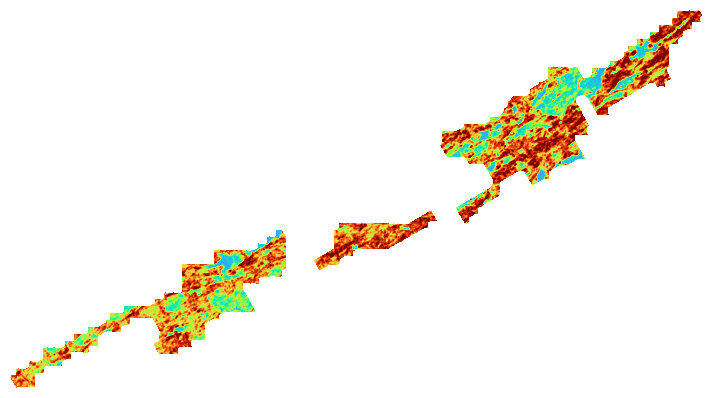

Critical_1xd_sum_r3


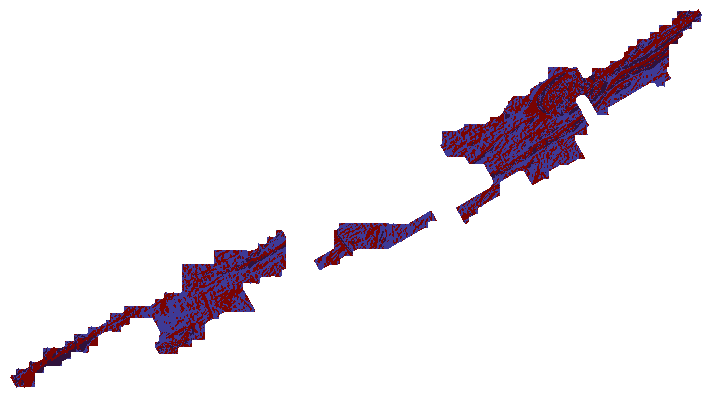

cre_dtm_curvature_mean_r3


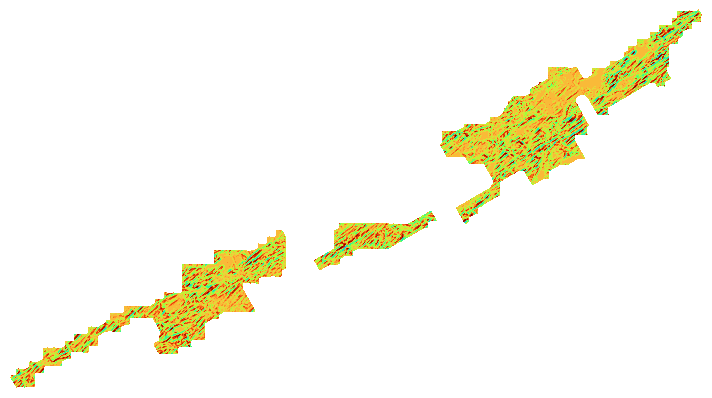

Critical_1yd_range_r3


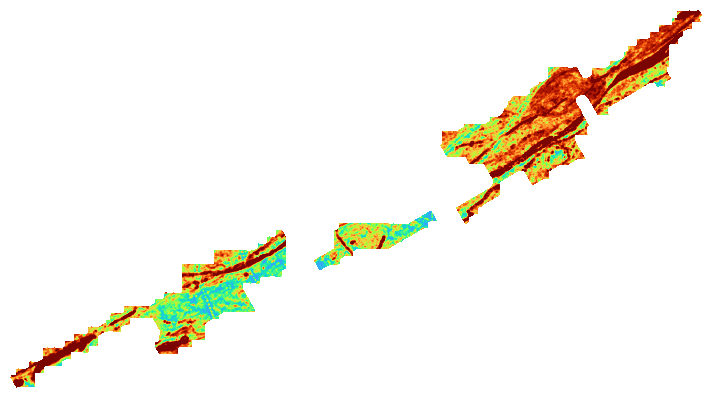

Critical_DTM_slope_var_r3


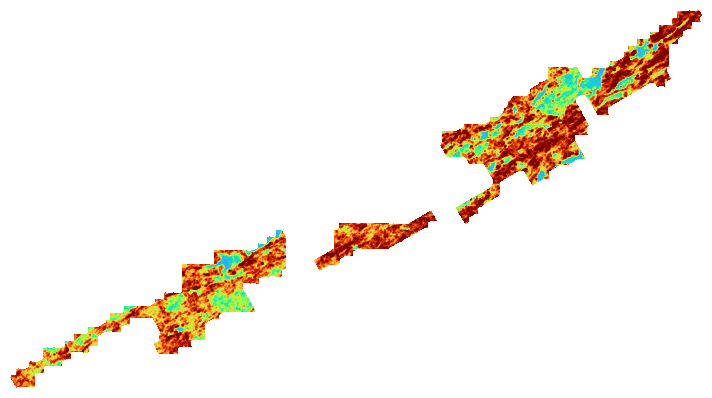

Critical_1xd_mean_r3


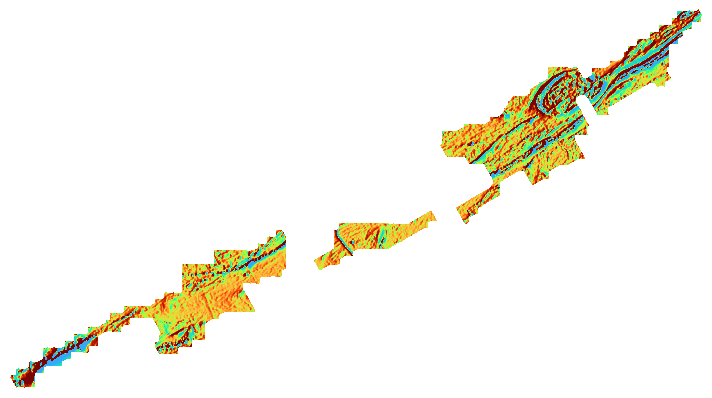

cre_dtm_curvature_max_r3


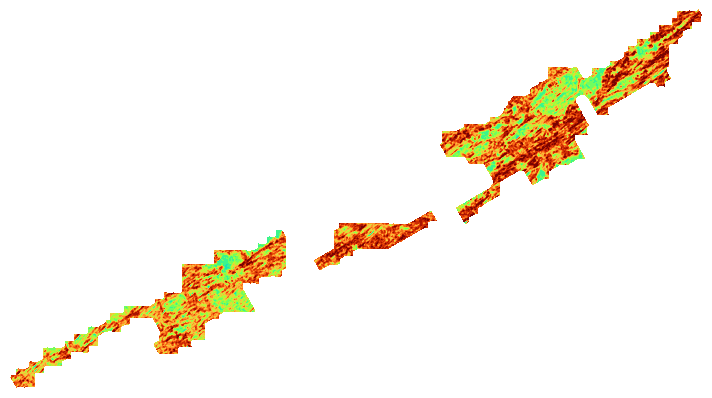

Critical_1xd_var_r3


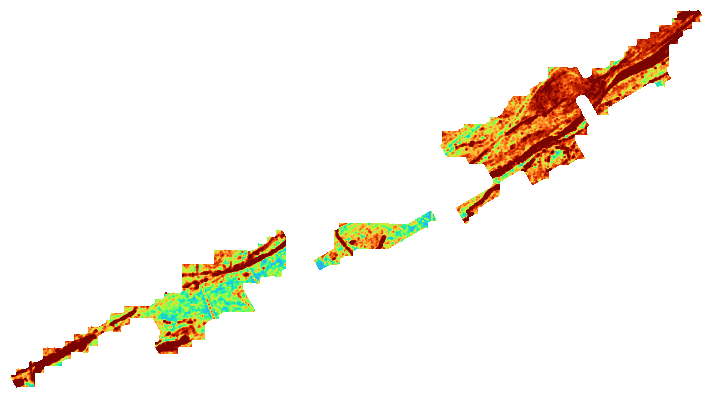

Critical_1yd_min_r3


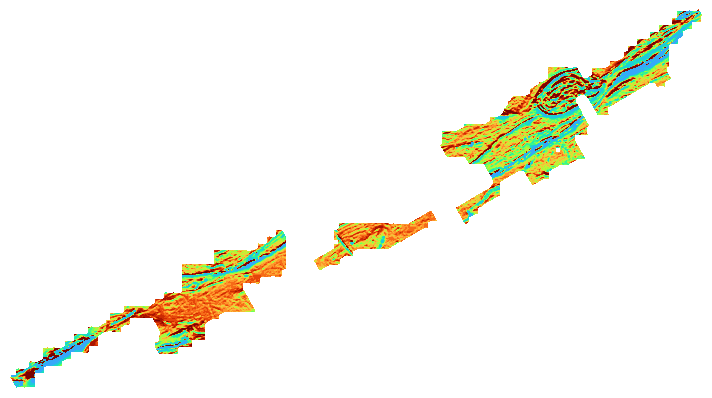

Critical_1yd_sum_r3


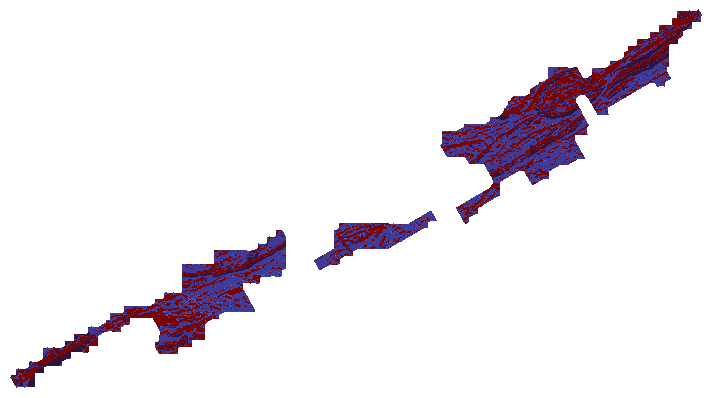

cre_dtm_curvature_min_r3


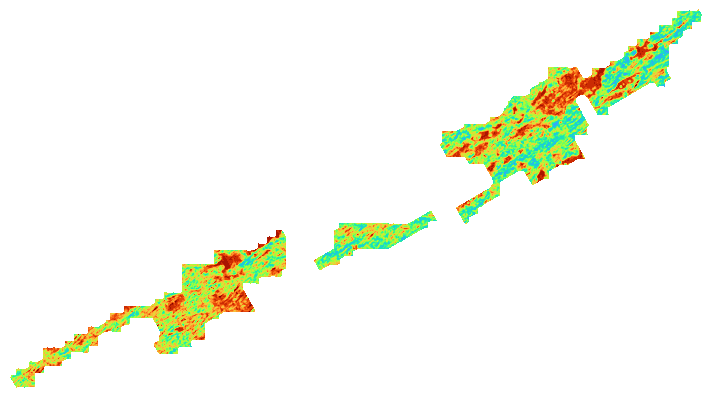

Critical_1xd_std_r3


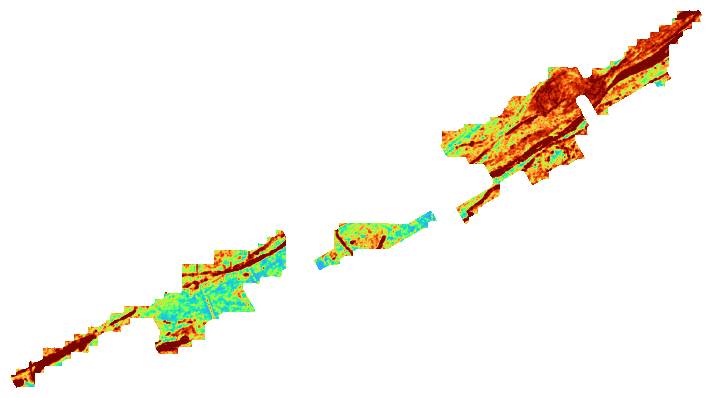

Critical_1xd_max_r3


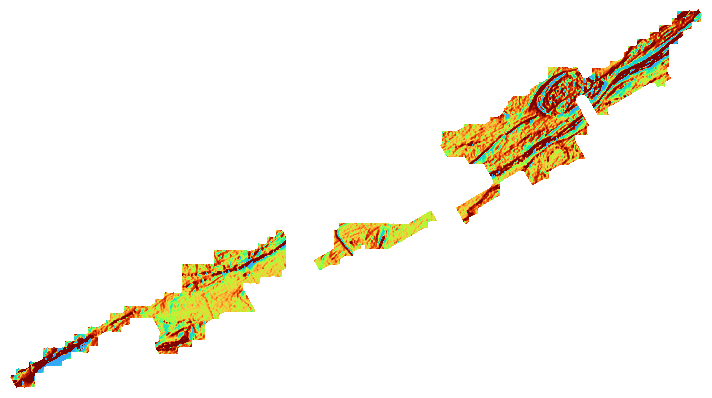

In [31]:
filepath = 'Inputs/Features/Raster/moving_windows_r3/'
tifs = glob.glob(filepath + '*.tif')

for t in tifs:
    filename,  extension, directory= utilities.Path_Info(t)
    print(filename)
    geotiff_to_jpg(t, os.path.join(filepath, filename + '.jpg'))